In [1]:
import numpy as np

In [2]:
import yt
import trident
import unyt

In [3]:
import pylab as pl
from astropy import units as un, constants as cons
from numpy import log10 as log

In [4]:
import h5py

In [5]:
from scipy.spatial.transform import Rotation

# Parameters

In [10]:
# Filetree
snapshot_fps = ('../../data/snapshot_277.0.hdf5',
                '../../data/snapshot_277.1.hdf5',
                '../../data/snapshot_277.2.hdf5',
                '../../data/snapshot_277.3.hdf5')
ray_fp = 'trident_ray.h5'
spectrum_fp = 'trident_spectrum.h5'
spectrum_plot_fp = 'trident_spectrum.pdf'

In [11]:
# Manual input of halo data parameters.
# Get these however you would normally.
# All units in kpc.
r_vir = 209.51/0.7*0.5 #262.
halo_center = np.array([21203.73992905, 21635.62597137, 22624.56860757])
j_vec = np.array([-0.10450846,  0.66726057, -0.73745597]) 

In [12]:
#check y
y = np.array([ -16.34418529,  104.35356085, -115.33149133])
y / np.linalg.norm( y )

array([-0.10450846,  0.66726057, -0.73745597])

In [13]:
fs = [h5py.File(snapshot_fp) for snapshot_fp in snapshot_fps]
f = fs[0]

In [14]:
h = f['Header'].attrs['HubbleParam']
print(h)

0.702


In [15]:
# check halo_center
a=(1+1)**-1
halo_center_base = np.array([29770.05086038,30376.4188638,31764.89432503])
print(halo_center_base/h*a)

[21203.73992905 21635.62597137 22624.56860757]


In [16]:
j_vec /= np.linalg.norm(j_vec)
rotvec = np.cross(j_vec,np.array([0,1,0]))
sin_theta = np.linalg.norm(rotvec)
rotvec_normed = -rotvec / sin_theta * np.arcsin(sin_theta)  # minus is to be consistent with direction bug
rot1 = Rotation.from_rotvec(rotvec_normed)  

In [17]:
x_hat  = rot1.apply(np.array([1,0,0]),inverse=True)
y_hat = rot1.apply(np.array([0,1,0]),inverse=True)
np.dot(x_hat,y_hat)

6.938893903907228e-18

In [18]:
#these should be the same but they are not due to direction bug in
#projection plot in ICV paper
y_hat,j_vec 

(array([0.10450846, 0.66726057, 0.73745597]),
 array([-0.10450846,  0.66726057, -0.73745597]))

In [19]:
# Sightline parameters.
# Sightline is impact_parameter offset from the center along the z-axis,
# runs perpendicular to the z-axis,
# and has a length of path_length.
path_length = 0.4 * r_vir
d = path_length/2

In [20]:
coords = np.concatenate([f['PartType0']['Coordinates'][:] for f in fs],axis=0)/h*a - halo_center

In [21]:
rot_coords = rot1.apply(coords)

In [22]:
epsilons = np.concatenate([f['PartType0']['InternalEnergy'][:] for f in fs],axis=0)[:]
Ts = (un.km**2/un.s**2 * cons.m_p / cons.k_B).to('K').value * (2./3* 0.62) * epsilons 

In [23]:
ls = np.concatenate([f['PartType0']['SmoothingLength'][:] for f in fs],axis=0)[:]
Ms = np.concatenate([f['PartType0']['Masses'][:] for f in fs],axis=0)[:]
rhos = np.concatenate([f['PartType0']['Density'][:] for f in fs],axis=0)[:]

In [24]:
0.04*r_vir

5.986000000000001

In [25]:
inds = ((rot_coords[:,2]<6) & (rot_coords[:,2]>-6) &
        (np.abs(rot_coords[:,0])<d) &(np.abs(rot_coords[:,1])<d))

In [26]:
inds.sum()

1181930

[]

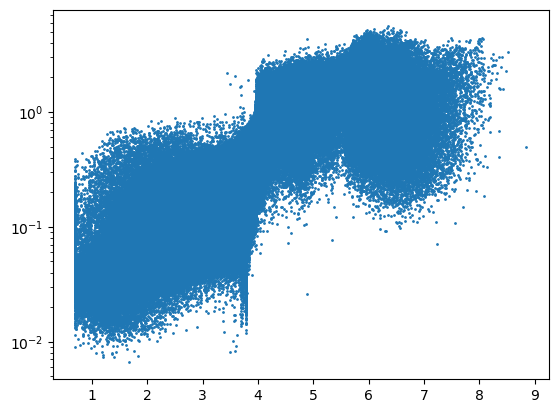

In [27]:
pl.scatter(log(Ts[inds]),ls[inds],s=1)
pl.semilogy()

Text(0, 0.5, 'y')

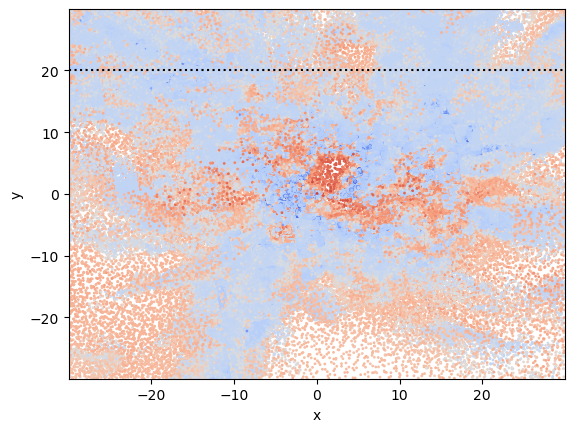

In [28]:
pl.scatter(rot_coords[inds][:,0],rot_coords[inds][:,1],c=(log(Ts[inds])-4)/2,cmap='coolwarm',s=1)
pl.xlim(-d,d)
pl.ylim(-d,d)
pl.axhline(20,c='k',ls=':')
pl.xlabel('x')
pl.ylabel('y')

In [29]:
inds = ((rot_coords[:,1]<23) & (rot_coords[:,1]>17) &
        (np.abs(rot_coords[:,0])<d) &(np.abs(rot_coords[:,2])<d))

Text(0, 0.5, 'z')

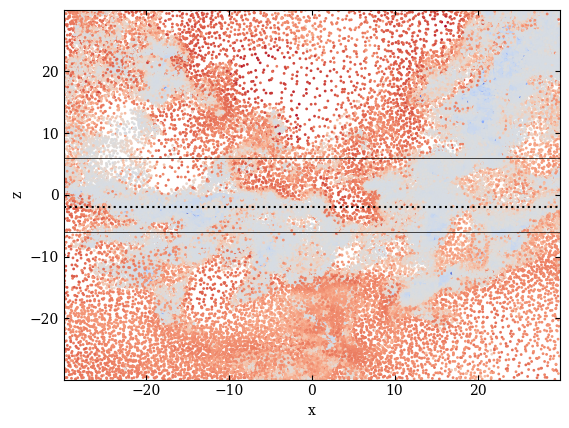

In [80]:
pl.scatter(rot_coords[inds][:,0],rot_coords[inds][:,2],c=(log(Ts[inds])-4)/2,cmap='coolwarm',s=1)
pl.xlim(-d,d)
pl.ylim(-d,d)
pl.axhline(-2,c='k',ls=':')
#depth limits of plot above:
pl.axhline(0.04*r_vir,c='k',ls='-',lw=0.5)
pl.axhline(-0.04*r_vir,c='k',ls='-',lw=0.5)
pl.xlabel('x')
pl.ylabel('z')

In [81]:
impact_parameter = 20
z_hat = np.cross(x_hat,y_hat)
z_offset = -2*z_hat
sl_center = halo_center + impact_parameter * y_hat + z_offset
sl_start = sl_center - path_length / 2. * x_hat
sl_end = sl_center + path_length / 2. * x_hat

In [98]:
20/(0.2*r_vir)

0.6682258603407951

# Generate Mock Observation

In [82]:
# Load the simulation data
ds = yt.load( snapshot_fps[0] )

yt : [INFO     ] 2023-01-25 18:22:45,920 Calculating time from 5.000e-01 to be 1.890e+17 seconds
yt : [INFO     ] 2023-01-25 18:22:45,921 Assuming length units are in kpc/h (comoving)
yt : [INFO     ] 2023-01-25 18:22:45,971 Parameters: current_time              = 1.8897164778779648e+17 s
yt : [INFO     ] 2023-01-25 18:22:45,972 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-01-25 18:22:45,973 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-01-25 18:22:45,974 Parameters: domain_right_edge         = [60000. 60000. 60000.]
yt : [INFO     ] 2023-01-25 18:22:45,974 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-01-25 18:22:45,975 Parameters: current_redshift          = 1.000000008126844
yt : [INFO     ] 2023-01-25 18:22:45,975 Parameters: omega_lambda              = 0.728
yt : [INFO     ] 2023-01-25 18:22:45,975 Parameters: omega_matter              = 0.272
yt : [INFO     ] 2023-01-25 18:22:45,976 Parameters: omega_radiation 

In [83]:
# Get the simulation kpc unit.
# This avoids a bug that sometimes pops up.
kpc = ds.quan( 1, 'kpc' )

In [121]:
# Other parameters
line_list = ['Mg','Si']#['H', 'C', 'N', 'O', 'Mg']

In [122]:
ray = trident.make_simple_ray(
    ds,
    start_position = sl_start * kpc,
    end_position = sl_end * kpc,
    data_filename = ray_fp,
    lines = line_list,
)

yt : [INFO     ] 2023-01-25 23:04:48,377 Getting segment at z = 1.000000008126844: [0.49552282 0.50669363 0.52976088] unitary to [0.49691436 0.50654725 0.52969613] unitary.
yt : [INFO     ] 2023-01-25 23:04:48,379 Getting subsegment: [0.49552282 0.50669363 0.52976088] unitary to [0.49691436 0.50654725 0.52969613] unitary.
yt : [INFO     ] 2023-01-25 23:06:26,926 Saving field data to yt dataset: trident_ray.h5.
yt : [INFO     ] 2023-01-25 23:06:26,962 Parameters: current_time              = 1.8897164778779648e+17 s
yt : [INFO     ] 2023-01-25 23:06:26,963 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-01-25 23:06:26,964 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2023-01-25 23:06:26,965 Parameters: domain_right_edge         = [60000. 60000. 60000.] code_length
yt : [INFO     ] 2023-01-25 23:06:26,966 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-01-25 23:06:26,966 Parameters: current_redshift          = 1.00000

In [140]:
a = ds.scale_factor
my_label   = ['MgII 2803','MgII 2796']
field      = 'Mg_p1_number_density'
wavelength = 2803.531, 2796.352 # Angstroms
f_value    = 0.303, 0.608
gamma      = 6.265e+08
mass       = 24.305
dlambda = 0.01
spectral_resolutions = (2000,20000,200000)
vs,flux = [None]*len(spectral_resolutions), [None]*len(spectral_resolutions)
for i,spectral_resolution in enumerate(spectral_resolutions):
    wl = 1206 #wavelength[1]
    sg = trident.SpectrumGenerator(lambda_min = 1100/a,lambda_max = 1300/a,dlambda=dlambda, bin_space='wavelength')
    #sg.add_line_to_database('Mg','II',wavelength[iLine], f_value=f_value[iLine], gamma=gamma, field=field)
    sg.make_spectrum(ray,lines=['Si III'],store_observables = True)
    lsf_width = wl/spectral_resolution / dlambda
    sg.apply_lsf(function='gaussian',width=lsf_width)
    sg.save_spectrum( 'yoyo4.h5' )
    f = h5py.File('yoyo4.h5')
    vs[i], flux[i] = (f['wavelength'][:]*a/wl - 1)*3e5,f['flux'][:]
    f.close()

yt : [INFO     ] 2023-01-25 23:14:38,386 Setting instrument to Custom
yt : [INFO     ] 2023-01-25 23:14:38,396 Creating spectrum
Adding line - Si III 1206 [1206.500000 A]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1285/1286 [00:00<00:00, 4620.94it/s]
yt : [INFO     ] 2023-01-25 23:14:38,738 Applying specified line spread function.
yt : [INFO     ] 2023-01-25 23:14:38,755 Writing spectrum to hdf5 file: yoyo4.h5.
yt : [INFO     ] 2023-01-25 23:14:38,759 Setting instrument to Custom
yt : [INFO     ] 2023-01-25 23:14:38,764 Creating spectrum
Adding line - Si III 1206 [1206.500000 A]: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1285/1286 [00:00<00:00, 3104.30it/s]
yt : [INFO     ] 2023-01-25 23:14:39,172 Applying specified line spread function.
yt : [INFO     ] 2023-01-25 23:14:39,174 Writing spectrum to hdf5 fi

In [141]:
sg.line_observables_dict['Si III 1206']

{'column_density': unyt_array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
             3.86848168e+10, 7.15160894e+00, 3.32782184e+10], 'cm**(-2)'),
 'tau_ray': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.62305604e-01, 3.52287313e-12, 1.39396915e-01]),
 'EW': unyt_quantity(1.65637729, 'Å'),
 'delta_lambda': unyt_array([1207.08679526, 1207.13782059, 1207.00863754, ...,
             1207.23531718, 1207.38339001, 1207.37843075], 'dimensionless*Å'),
 'lambda_obs': unyt_array([2413.58679526, 2413.63782059, 2413.50863754, ...,
             2413.73531718, 2413.88339001, 2413.87843075], 'Å'),
 'thermal_b': unyt_array([4.57782899e-06, 4.62625204e-06, 4.38868223e-06, ...,
             7.11478937e-07, 1.52184527e-06, 4.14109561e-07], 'sqrt(erg)/sqrt(amu)'),
 'thermal_width': unyt_array([0.28600739, 0.28903881, 0.27418126, ..., 0.04445355,
             0.09509147, 0.0258753 ], 'Å')}

In [116]:
EWs_opt_thin = sg.line_observables_dict['Mg II 2796']['column_density']*f_value[1]/1.13e12*(1.*unyt.cm).to('angstrom')

# Plot Ray Properties

In [142]:
# Get property fields
temp = ray.r[('gas', 'temperature')]
dens = ray.r[('gas','H_nuclei_density')]
#metallicity = ray.r[('gas', 'O_metallicity')]
fmgII = ray.r[('gas', 'Mg_p1_ion_fraction')]
fsiII  = ray.r[('gas', 'Si_p1_ion_fraction')]
fsiIII = ray.r[('gas', 'Si_p2_ion_fraction')]
vCenter = np.array([-58.64,82.05,86.61])
vCenter_los = np.dot(vCenter,x_hat)*unyt.km/unyt.s
vlos = ray.r[('gas','velocity_los')].to('km/s') + vCenter_los

In [143]:
# Get coordinates and convert to relevant frame
coords = np.array([ ray.r[('gas', _)].to( 'kpc' ) for _ in ( 'x', 'y', 'z' ) ]).transpose()
coords -= sl_center
d_along_sightline = np.dot( coords, x_hat )

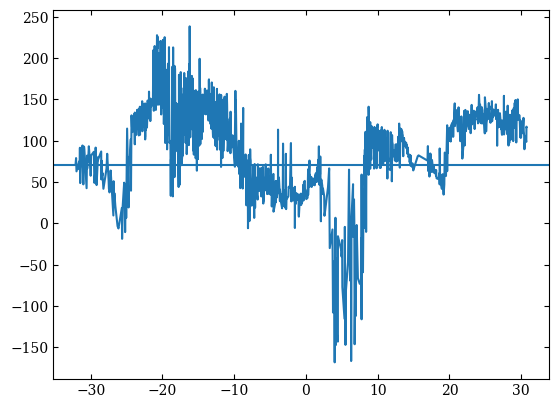

In [144]:
pl.plot(d_along_sightline,ray.r[('gas','velocity_los')].to('km/s'))
pl.axhline(-vCenter_los)

In [145]:
import sys
sys.path.append('../../pysrc')
import projectPlotBasics
import my_utils as u

In [146]:
import matplotlib
from matplotlib import gridspec

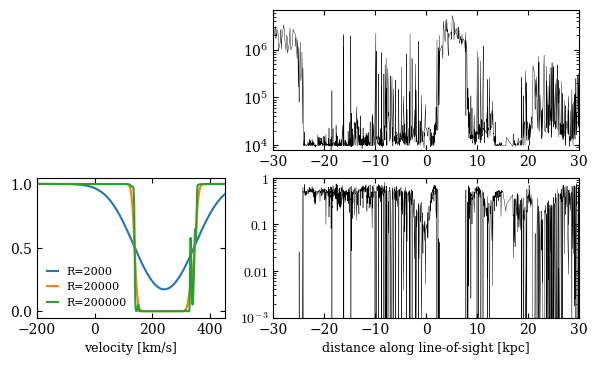

In [154]:
fig = pl.figure(figsize=(7,4))
gs = gridspec.GridSpec(nrows=2,ncols=5,wspace=0.7)
ax = fig.add_subplot(gs[0,2:])
ax.plot(d_along_sightline,temp,lw=0.3,c='k')
ax.set_yscale( 'log' )
ax.set_xlim(-30,30)
#ax.set_ylabel(r'$T\ [{\rm K}]$' )
pl.ylim(0.8e4,7e6)
ax = fig.add_subplot(gs[1,2:])
#ax.plot(d_along_sightline,fsiII+fsiIII,lw=0.3,c='b')
ax.plot(d_along_sightline,fsiIII,lw=0.3,c='k')
#ax.plot(d_along_sightline,np.e**-sg.line_observables_dict['Mg II 2796']['tau_ray'],lw=0.3,c='k')
#ax.plot(d_along_sightline,sg.line_observables_dict['Mg II 2796']['column_density'].cumsum(),lw=0.3,c='k')
ax.set_xlim(-30,30)
ax.set_yscale( 'log' ); ax.yaxis.set_major_formatter(u.arilogformatter)
pl.ylim(1e-3,1)
#ax.set_ylabel('MgII fraction',fontsize=9 )
ax.set_xlabel( 'distance along line-of-sight [kpc]',fontsize=9 )
ax = fig.add_subplot(gs[1,:2])
for i,spectral_resolution in enumerate(spectral_resolutions):
    pl.plot(vs[i],flux[i],label=r'R=%d'%spectral_resolution)
pl.xlim(-200,450)
pl.legend(fontsize=8,handlelength=1,frameon=False)
ax.set_xlabel( 'velocity [km/s]',fontsize=9 )
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
pl.savefig( 'sightline.pdf' )
# ax = pl.subplot(221)
# 
# ax.set_xlim( - path_length / 2., path_length / 2)
# ax.set_ylabel( r'$v_{\rm los}$' )
#ax.yaxis.set_major_formatter(u.arilogformatter)

In [94]:
path_length

59.86000000000001

Text(0.5, 0, 'distance along sightline [kpc]')

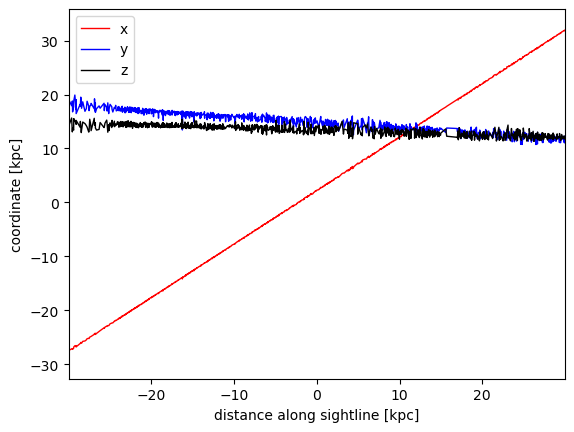

In [41]:
fig = plt.figure()
ax = plt.gca()

for i,d in enumerate('xyz'):
    ax.plot(
        d_along_sightline,
        ray.r[('gas', d)].to('kpc')-halo_center[i]*unyt.kpc,
        linewidth = 1,
        color = 'rbk'[i],label=d
)
pl.legend()
ax.set_xlim( - path_length / 2., path_length / 2)
ax.set_ylabel( 'coordinate [kpc]' )
ax.set_xlabel( 'distance along sightline [kpc]' )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'r_3D [kpc]')

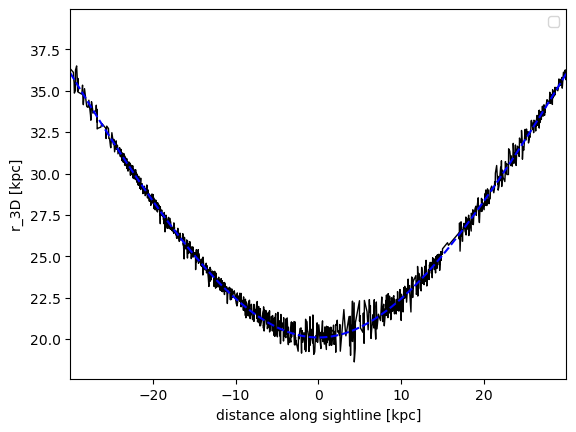

In [44]:
fig = plt.figure()
ax = plt.gca()

ax.plot(
    d_along_sightline,
    ((ray.r[('gas', 'x')].to('kpc')-halo_center[0]*unyt.kpc)**2 +
    (ray.r[('gas', 'y')].to('kpc')-halo_center[1]*unyt.kpc)**2 + 
    (ray.r[('gas', 'z')].to('kpc')-halo_center[2]*unyt.kpc)**2)**0.5,
    linewidth = 1,
    color = 'rbk'[i]
)
pl.legend()
ax.set_xlim( - path_length / 2., path_length / 2)
pl.plot(d_along_sightline,(20**2+2**2+d_along_sightline**2)**0.5,c='b',ls='--')
ax.set_xlabel( 'distance along sightline [kpc]' )
ax.set_ylabel( 'r_3D [kpc]' )

In [66]:
1e13*0.606/1.13e12

5.3628318584070795

# YT attempts

In [ ]:
smoothing_field = ("gas", "density")
_, center = ds.find_max(smoothing_field)
sp = ds.sphere(center, (10, "kpc"))
normal_vector = sp.quantities.angular_momentum_vector()
prj = yt.OffAxisProjectionPlot(ds, normal_vector, smoothing_field, center, (20, "kpc"))



yt : [INFO     ] 2023-01-25 12:45:17,756 max value is 3.85398e-20 at 29766.3403420530448784 30377.0059094996468048 31766.0377274709462654


In [72]:
smoothing_field = ("gas", "density")
_, center = ds.find_max(smoothing_field)
sp = ds.sphere(center, (10, "kpc"))
normal_vector = sp.quantities.angular_momentum_vector()
prj = yt.OffAxisProjectionPlot(ds, normal_vector, smoothing_field, center, (20, "kpc"))



yt : [INFO     ] 2023-01-25 12:45:17,756 max value is 3.85398e-20 at 29766.3403420530448784 30377.0059094996468048 31766.0377274709462654
yt : [INFO     ] 2023-01-25 12:48:01,747 xlim = -14.040000 14.040000
yt : [INFO     ] 2023-01-25 12:48:01,747 ylim = -14.040000 14.040000
yt : [INFO     ] 2023-01-25 12:48:01,747 zlim = -30000.000000 30000.000000
yt : [INFO     ] 2023-01-25 12:48:01,750 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



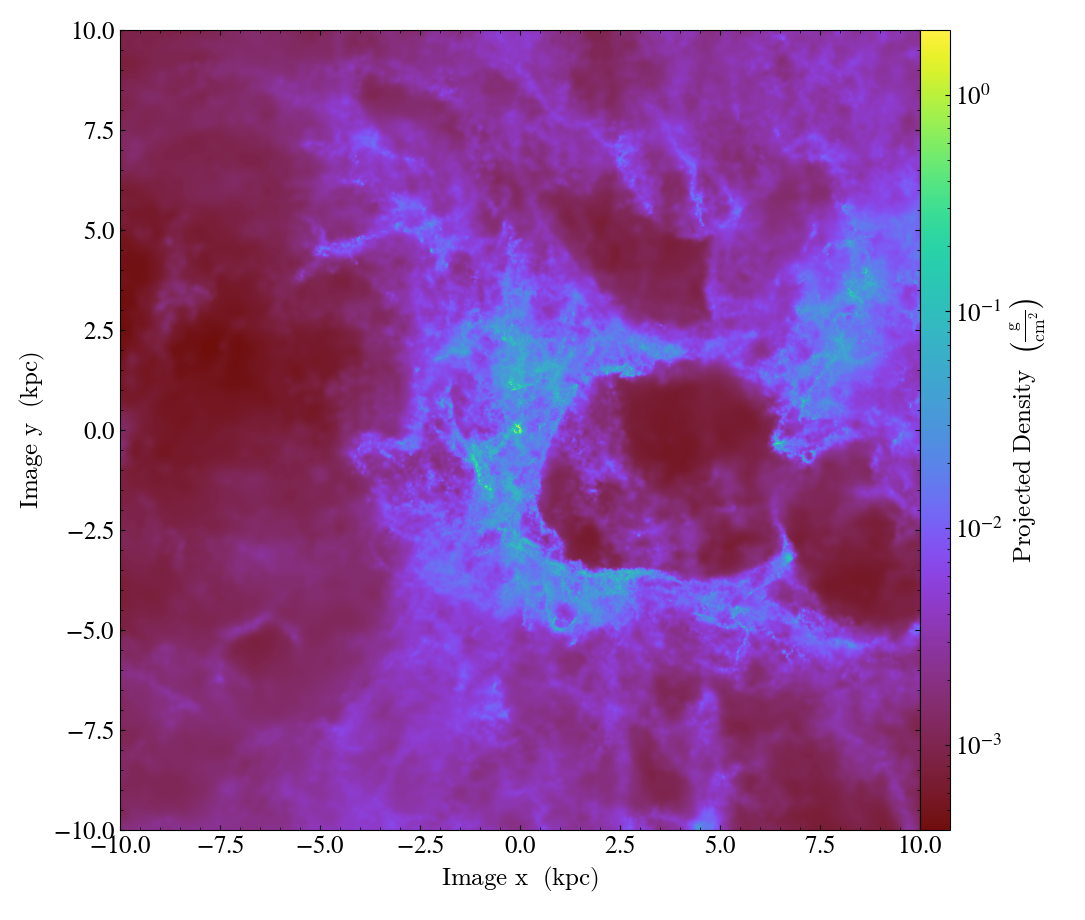

In [75]:
prj.show()

In [90]:
def _log_temperature(field, data):
    return np.log10(data["gas", "temperature"])

In [93]:
ds.add_field(
    name=("gas", "log_temperature"),
    function=_log_temperature,
    sampling_type="local",
    units="",
)

In [99]:
_, center = ds.find_max(smoothing_field)

yt : [INFO     ] 2023-01-25 13:10:07,269 max value is 6.54166e+08 at 29769.0889290435407020 30371.7491938894454506 31764.6885557039495325


In [100]:
center, halo_center_base

(unyt_array([29769.08892904, 30371.74919389, 31764.6885557 ], 'code_length'),
 array([29770.05086038, 30376.4188638 , 31764.89432503]))

In [124]:
logTs = ds.all_data()[field]

In [152]:
field = ("gas", "log_temperature")
weight_field = ('gas','density')
prj = yt.OffAxisProjectionPlot(ds, normal=z_hat, fields=field, 
                               center = halo_center*kpc, width = (5*60, "kpc"),
                              depth = (12,'kpc'),north_vector=y_hat,method='integrate',
                              buff_size=(100, 100),weight_field = weight_field)


yt : [INFO     ] 2023-01-25 13:52:01,259 xlim = -210.600001 210.600001
yt : [INFO     ] 2023-01-25 13:52:01,260 ylim = -210.600001 210.600001
yt : [INFO     ] 2023-01-25 13:52:01,260 zlim = -8.424000 8.424000
yt : [INFO     ] 2023-01-25 13:52:01,261 Making a fixed resolution buffer of (('gas', 'log_temperature')) 100 by 100


In [153]:
r_vir, 0.2*r_vir, 0.04*r_vir

(149.65, 29.930000000000003, 5.986000000000001)

yt : [WARNING  ] 2023-01-25 13:53:42,034 Converting length units from 2.197776045885979e+21 cm to cm.
yt : [INFO     ] 2023-01-25 13:53:42,036 Making a FITS image of field log_temperature


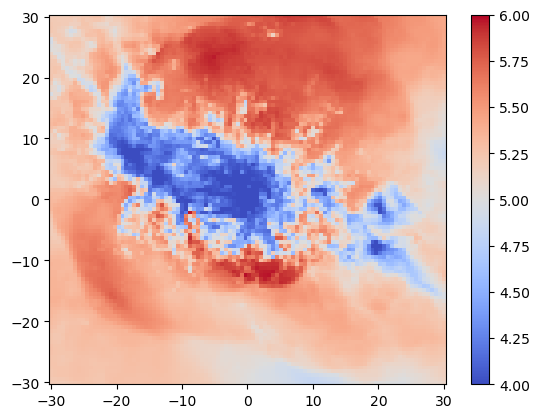

In [154]:
Xs = np.linspace(-30,30,100)
Ys = np.linspace(-30,30,100)
pl.pcolormesh(Xs,Ys,prj.to_fits_data()[field[1]].data.T,cmap='coolwarm',vmin=4,vmax=6)
pl.colorbar()